In [1]:
import os
import pandas as pd
import math
import numpy as np
import cv2
import keras
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras import models, layers
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from tensorflow.keras.applications import VGG16

In [2]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/data

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/data


In [3]:
csv_file = pd.read_csv('data.csv')
%cd /content/drive/MyDrive/data/images

/content/drive/MyDrive/data/images


In [4]:
classes = csv_file['name'].unique()
print(classes)
labels = dict()
for i in range(len(classes)):
    labels.update({i : classes[i]})
print(labels)

['Speed Limit 70' 'Speed Limit 50' 'Speed Limit 100' 'No Entry'
 'Speed Limit 80' 'Speed Limit 120' 'RedSignal' 'Speed Limit 30'
 'Turn Left' 'Stop' 'GreenSignal' 'Road Work' 'Right Curve Ahead'
 'Speed Limit 60' 'Go Straight' 'No Over Taking' 'Danger Ahead' 'Give Way'
 'Go Right or Straight' 'Pedestrian' 'Right Sharp Curve'
 'Left Sharp Curve' 'Turn Right' 'Snow Warning Sign'
 'No Over Taking Trucks' 'Left Curve Ahead' 'No Waiting'
 'Traffic Signals Ahead' 'Slippery Road' 'Huddle Road' 'Deer Zone'
 'End of Right Road (Go straight)' 'No Stopping' 'Truck Sign'
 'Go Left or Straight' 'Cycle Zone' 'RoundAbout' 'YellowSignal']
{0: 'Speed Limit 70', 1: 'Speed Limit 50', 2: 'Speed Limit 100', 3: 'No Entry', 4: 'Speed Limit 80', 5: 'Speed Limit 120', 6: 'RedSignal', 7: 'Speed Limit 30', 8: 'Turn Left', 9: 'Stop', 10: 'GreenSignal', 11: 'Road Work', 12: 'Right Curve Ahead', 13: 'Speed Limit 60', 14: 'Go Straight', 15: 'No Over Taking', 16: 'Danger Ahead', 17: 'Give Way', 18: 'Go Right or Strai

In [5]:
csv_file['name'] = csv_file['name'].replace(labels.values(), range(len(classes)))

**Data Pre-Processing**

Для роботи з зображеннями нам необхідно зробити інтерполяцію, щоб всі дані мали один  вимір. Розмір зображень знаходиться у великому діапазоні, виберемо `256*256*3`. Використаємо метод `resize ` з бібліотеки `OpenCV`.

In [6]:
def resize_im(img):
    return cv2.resize(img, (64, 64), interpolation = cv2.INTER_AREA)

**Data Loading**

In [7]:
list_images = []
out = []
data_dir = os.getcwd()

for row in csv_file.iterrows() :
    img_path = os.path.join(data_dir, row[1].filename)
    img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    img = img[row[1]['ymin']:row[1]['ymax'], row[1]['xmin']:row[1]['xmax'],:]
    img = resize_im(img)
    img = np.array(img)
    list_images.append(img)
    out.append(row[1]['name'])
data = np.array(list_images)
output = np.array(out)

In [8]:
output

array([0, 0, 1, ..., 6, 6, 9])

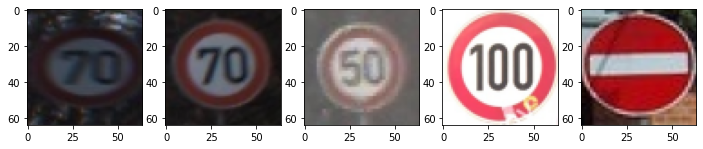

In [9]:
plt.figure(figsize = (12,12))

for i in range(5) :
    plt.subplot(1, 5, i+1)
    plt.imshow(data[i])

plt.show()

In [10]:
def prep_dataset(X,y):
    X_prep = X.astype('float32')
    y_prep = to_categorical(np.array(y))
    return (X_prep, y_prep)

X, y = prep_dataset(data,output)

In [11]:
X_train, X_val, y_train, y_val = train_test_split(X,y, test_size=0.2, shuffle=True, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_val,y_val, test_size=0.5, shuffle=True)

In [12]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(3720, 64, 64, 3)
(3720, 38)
(465, 64, 64, 3)
(465, 38)


In [13]:
def print_accuracy(y_test, y_pred):
  print('- Test dataset Acuracy achieved: {:.2f}%\n- Accuracy by model was: {:.2f}%\n- Accuracy by validation was: {:.2f}%'.
        format(accuracy_score(y_test,y_pred)*100,(history.history['accuracy'][-1])*100,(history.history['val_accuracy'][-1])*100))

In [14]:
def conf_matrix(y_test, y_pred):
  conf_mat=confusion_matrix(y_test,y_pred)
  labels=list(range(0,38))
  f,ax=plt.subplots(figsize=(20,18))
  sns.heatmap(conf_mat,annot=True,fmt='.0f')
  ax.set_xticklabels(labels)
  ax.set_yticklabels(labels)
  plt.show()

**CNN Model**

In [15]:
model = models.Sequential() #Sequential Model

#ConvLayer(32 filters) + MaxPooling + BatchNormalization + Dropout
model.add(layers.Conv2D(filters=32,kernel_size=3,activation='relu',padding='same',input_shape=X.shape[1:]))
model.add(layers.MaxPool2D(strides=2))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.3))

#ConvLayer(128 filters) + MaxPooling + BatchNormalization + Dropout
model.add(layers.Conv2D(filters=128,kernel_size=3,activation='relu',padding='same'))
model.add(layers.MaxPool2D(strides=2))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.3))

#ConvLayer(512 filters) + Dropout + ConvLayer(512 filters) + MaxPooling + BatchNormalization
model.add(layers.Conv2D(filters=512,kernel_size=3,activation='relu',padding='same'))
model.add(layers.Dropout(0.3))
model.add(layers.Conv2D(filters=512,kernel_size=3,activation='relu',padding='same'))
model.add(layers.MaxPool2D(strides=2))
model.add(layers.BatchNormalization())

#Flatten
model.add(layers.Flatten())

#2 Dense layers with 4000 hidden units
model.add(layers.Dense(4000,activation='relu'))
model.add(layers.Dense(4000,activation='relu'))

#Dense layer with 1000 hidden units
model.add(layers.Dense(1000,activation='relu'))

#Softmax layer for output
model.add(layers.Dense(38,activation='softmax'))

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 128)       36992     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 128)      0

In [16]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
history= model.fit(X_train,y_train,epochs=30,batch_size=64,validation_data=(X_val,y_val), shuffle=True)

Epoch 1/30
59/59 [==============================] - 11s 119ms/step - loss: 6.3698 - accuracy: 0.2556 - val_loss: 2.8313 - val_accuracy: 0.1871
Epoch 2/30
59/59 [==============================] - 5s 80ms/step - loss: 1.7974 - accuracy: 0.4196 - val_loss: 1.8490 - val_accuracy: 0.4215
Epoch 3/30
59/59 [==============================] - 5s 81ms/step - loss: 1.3124 - accuracy: 0.5675 - val_loss: 2.8079 - val_accuracy: 0.3269
Epoch 4/30
59/59 [==============================] - 5s 81ms/step - loss: 0.8528 - accuracy: 0.7207 - val_loss: 1.3854 - val_accuracy: 0.6000
Epoch 5/30
59/59 [==============================] - 5s 81ms/step - loss: 0.5196 - accuracy: 0.8228 - val_loss: 0.9729 - val_accuracy: 0.7204
Epoch 6/30
59/59 [==============================] - 5s 82ms/step - loss: 0.3476 - accuracy: 0.8895 - val_loss: 0.4581 - val_accuracy: 0.8624
Epoch 7/30
59/59 [==============================] - 5s 82ms/step - loss: 0.2145 - accuracy: 0.9336 - val_loss: 0.6216 - val_accuracy: 0.8043
Epoch 8/30


In [17]:
y_test = np.argmax(y_test,axis=1)
y_pred= model.predict(X_test)

y_pred = np.argmax(y_pred, axis=1)

In [18]:
print_accuracy(y_test, y_pred)

- Test dataset Acuracy achieved: 92.90%
- Accuracy by model was: 98.17%
- Accuracy by validation was: 94.62%


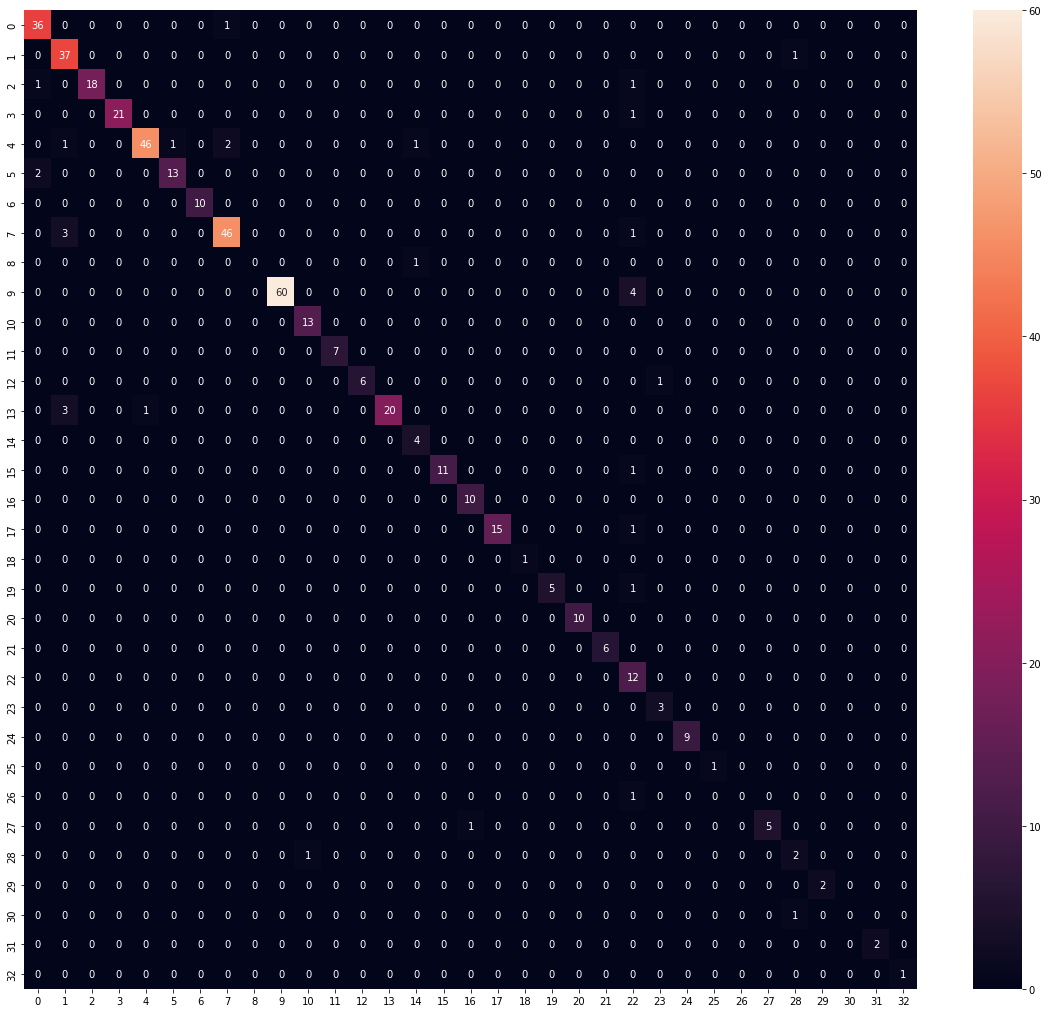

In [19]:
conf_matrix(y_test, y_pred)

In [20]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.92      0.97      0.95        37
           1       0.84      0.97      0.90        38
           2       1.00      0.90      0.95        20
           3       1.00      0.95      0.98        22
           4       0.98      0.90      0.94        51
           5       0.93      0.87      0.90        15
           6       1.00      1.00      1.00        10
           7       0.94      0.92      0.93        50
           8       0.00      0.00      0.00         1
           9       1.00      0.94      0.97        64
          10       0.93      1.00      0.96        13
          11       1.00      1.00      1.00         7
          12       1.00      0.86      0.92         7
          13       1.00      0.83      0.91        24
          14       0.67      1.00      0.80         4
          15       1.00      0.92      0.96        12
          16       0.91      1.00      0.95        10
          17       1.00    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


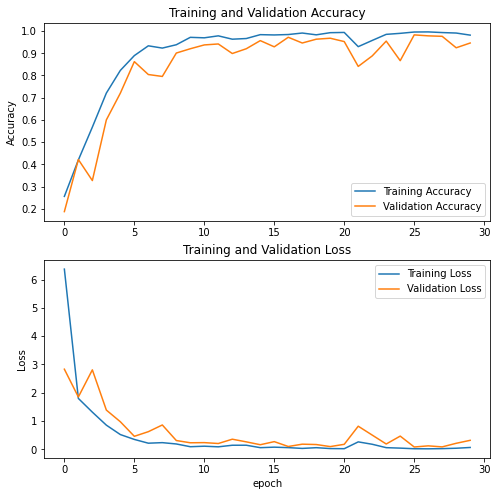

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

**VGG16 model**

In [22]:
input_layer=layers.Input(shape=(64,64,3))
model_vgg16=VGG16(weights='imagenet',input_tensor=input_layer,include_top=False)

In [28]:
last_layer=model_vgg16.output # last layer of the model

flatten=layers.Flatten()(last_layer) 

# Add dense layer
dense1=layers.Dense(4000,activation='relu')(flatten)
#dense2=layers.Dense(1000,activation='relu')(dense1)

# Add dense layer to the final output layer
output_layer=layers.Dense(38,activation='softmax')(dense1)

model=models.Model(inputs=input_layer,outputs=output_layer)
# we will freez all the layers except the last layer

# all the layers intrainable except the last layer
for layer in model.layers[:-1]:
    layer.trainable=False

model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0   

In [29]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
history= model.fit(X_train,y_train,epochs=20,batch_size=64,validation_data=(X_val,y_val), shuffle=True)

Epoch 1/20
59/59 [==============================] - 4s 53ms/step - loss: 11.3629 - accuracy: 0.5745 - val_loss: 2.1195 - val_accuracy: 0.7290
Epoch 2/20
59/59 [==============================] - 2s 36ms/step - loss: 0.6340 - accuracy: 0.8699 - val_loss: 0.8196 - val_accuracy: 0.8344
Epoch 3/20
59/59 [==============================] - 2s 35ms/step - loss: 0.3083 - accuracy: 0.9288 - val_loss: 0.9229 - val_accuracy: 0.8581
Epoch 4/20
59/59 [==============================] - 2s 35ms/step - loss: 0.2812 - accuracy: 0.9387 - val_loss: 0.8152 - val_accuracy: 0.8581
Epoch 5/20
59/59 [==============================] - 2s 35ms/step - loss: 0.1860 - accuracy: 0.9624 - val_loss: 0.6348 - val_accuracy: 0.8860
Epoch 6/20
59/59 [==============================] - 2s 35ms/step - loss: 0.1464 - accuracy: 0.9712 - val_loss: 0.6447 - val_accuracy: 0.8710
Epoch 7/20
59/59 [==============================] - 2s 35ms/step - loss: 0.1025 - accuracy: 0.9798 - val_loss: 0.6039 - val_accuracy: 0.9161
Epoch 8/20
5

In [30]:
y_pred= model.predict(X_test)

y_pred = np.argmax(y_pred, axis=1)

In [36]:
print_accuracy(y_test, y_pred)

- Test dataset Acuracy achieved: 90.54%
- Accuracy by model was: 99.68%
- Accuracy by validation was: 91.83%


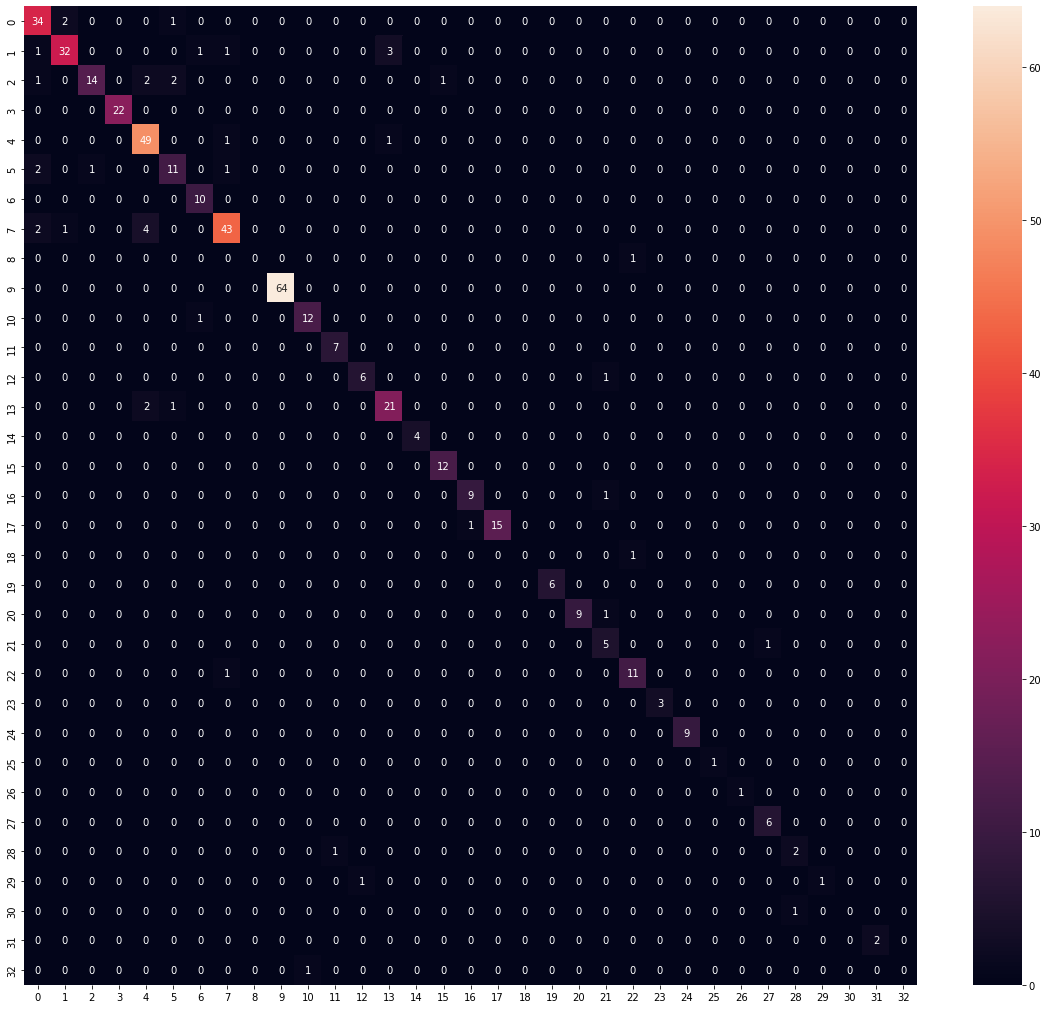

In [32]:
conf_matrix(y_test, y_pred)

In [33]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.85      0.92      0.88        37
           1       0.91      0.84      0.88        38
           2       0.93      0.70      0.80        20
           3       1.00      1.00      1.00        22
           4       0.86      0.96      0.91        51
           5       0.73      0.73      0.73        15
           6       0.83      1.00      0.91        10
           7       0.91      0.86      0.89        50
           8       0.00      0.00      0.00         1
           9       1.00      1.00      1.00        64
          10       0.92      0.92      0.92        13
          11       0.88      1.00      0.93         7
          12       0.86      0.86      0.86         7
          13       0.84      0.88      0.86        24
          14       1.00      1.00      1.00         4
          15       0.92      1.00      0.96        12
          16       0.90      0.90      0.90        10
          17       1.00    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


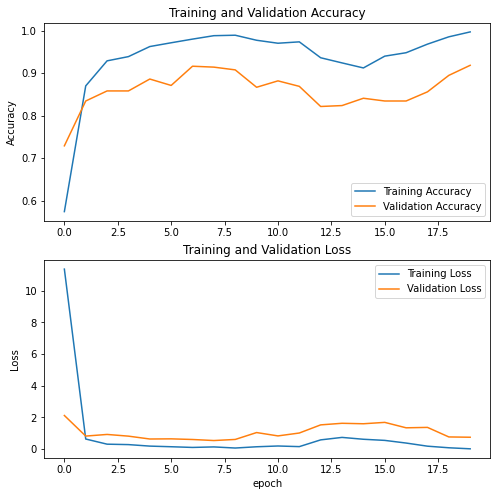

In [35]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()